## Related Python projects

- [a Kaggle notebook using BigQuery](https://www.kaggle.com/paultimothymooney/how-to-query-the-noaa-ghcn-daily-weather-data)
- [Get_NOAA_GHCN_data](https://github.com/aaronpenne/get_noaa_ghcn_data) - a python3 library to make it easier to access GHCN data

## Sources for historical weather data

- [weather underground](https://www.wunderground.com/history/daily/KRIC/date/2021-1-23) - private, ad supported - not intended for bulk download
- [national weather service](https://w2.weather.gov/climate/local_data.php?wfo=akq) - mostly aggregate PDFs
- [national climate data center](https://www.ncdc.noaa.gov/cdo-web/) - prominently offers paid access
    - [NCDC 2](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00013740/detail) - RIC station
- [NCEI](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00861/html) - very helpful dataset resource - provided NCDC GCHN public links

For one station, download from e.g. https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/USW00013740.dly
where in this case, Richmond International Airport has code 'USW00013740'

Station codes can be found in https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt

In [1]:
import pandas as pd
import numpy as np
import requests
import urllib.request
import os
from io import StringIO

In [34]:
station_id = 'USW00013740'
output_dir = 'ghcn_data'
os.environ["DLY_OUTPUT"] = output_dir

# download the daily file
#urllib.request.urlretrieve(f'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{station_id}.dly', f'{output_dir}/{station_id}.dly')

station_id_list = ['USW00013740','USC00440327','USC00448829','USC00444101','USC00445050']

# Stations

Source: https://www.ncdc.noaa.gov/cdo-web/datatools/findstation

- USW00013740 - RIC airport - 1939-03-01 to 2021-01-23
- USC00440327 - Ashland - 1893-01-01 to 2021-01-23
- USC00448829 - Walkerton 2 NW - 1932-07-01 to 2020-11-30
- USC00444101 - Hopewell - 1916-10-01 to 2021-01-20
- USC00445050 - Louisa - 1916-05-01 to 2021-01-23


In [3]:
# from https://github.com/aaronpenne/get_noaa_ghcn_data
import get_dly 
#station_id = 'USW00013740'
for s in station_id_list:
    ftp = get_dly.connect_to_ftp()
    get_dly.dly_to_csv(ftp, s)
    ftp.quit()


230-****** WARNING ** WARNING ** WARNING ** WARNING ** WARNING ** ** WARNING ** WARNING ** WARNING ******
 ** You are accessing a U.S. Government information system, which includes:                         **
 ** 1) This computer, 2)This computer network, 3) All computers connected to this network, and      **
 ** 4) All devices and storage media attached to this network or to a computer on this network.     **
 ** You understand and consent to the following:                                                    **
 ** you may access this information system for authorized use only; you have no reasonable          **
 ** expectation of privacy regarding any communication of data transiting or stored on this         **
 ** information system; at any time and for any lawful Government purpose, the Government may       **
 ** monitor, intercept, and search and seize any communication or data transiting or stored on      **
 ** this information system; and any communications or data transiting

,MM/DD/YYYY,ID,YEAR,MONTH,DAY,TMAX,TMAX_FLAGS,TMIN,TMIN_FLAGS,PRCP,...,WT04,WT04_FLAGS,WT05,WT05_FLAGS,DAPR,DAPR_FLAGS,MDPR,MDPR_FLAGS,WT06,WT06_FLAGS


In [35]:
#ric = pd.read_csv(station_id + '.csv')

# create a blank df using the columns from the first csv
sdf = pd.read_csv(output_dir + '/' + station_id_list[0] + '.csv', nrows=0)

# load all the files into one df
for s in station_id_list:
    df = pd.read_csv(output_dir + '/' + s + '.csv')
    sdf = sdf.append(df)

/home/kfinity/anaconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (14,24,26,48,50,52,56,58,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/kfinity/anaconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (14,26,28,34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/kfinity/anaconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (22,34,38,40,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/kfinity/anaconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.p

In [36]:
sdf.ID.unique()

array(['USW00013740', 'USC00440327', 'USC00448829', 'USC00444101',
       'USC00445050'], dtype=object)

In [37]:
# fix date column
sdf['DAY'] = pd.to_datetime(sdf['MM/DD/YYYY'], format='%Y-%m-%d')

# drop columns
sdf = sdf.loc[:,['DAY','ID','YEAR','MONTH','TMIN','TMAX']]


In [38]:
# convert TMIN from "tenths of degrees C" to F
sdf['TMIN_F'] = (sdf['TMIN'] /10 * 9/5) +32

In [39]:
# drop dates outside of min date (1939-03-01) for RIC station
sdf = sdf.loc[sdf['DAY'] >= datetime(1939, 3, 1)]

In [40]:
# first-last df
# max date in first half of year with frost (last frost date)
fl = sdf.loc[(sdf['MONTH']<7) & (sdf['TMIN_F']<=32.0),:].groupby(['YEAR','ID']).agg({'DAY': 'max'}).reset_index()
fl['LAST'] = pd.to_numeric(fl['DAY'].apply(lambda d: d.strftime('%j')))

In [41]:
# min date in second half of year with frost
fl['FIRST'] = pd.to_numeric(sdf.loc[(sdf['MONTH']>6) & (sdf['TMIN_F']<=32.0), :]\
                            .groupby(['YEAR','ID']).agg({'DAY': 'min'}).reset_index()['DAY']\
                            .apply(lambda d: d.strftime('%j')))
fl = fl.dropna() # probably drops the current year, if it doesn't have a first fall frost date yet.
fl['FIRST'] = fl['FIRST'].astype('int16')

In [42]:
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# convert day of year to month-day string labels
def j_to_md(x, pos):
    return datetime.strptime(str(int(x)), '%j').strftime('%b %d')
    
jmd_formatter = FuncFormatter(j_to_md)

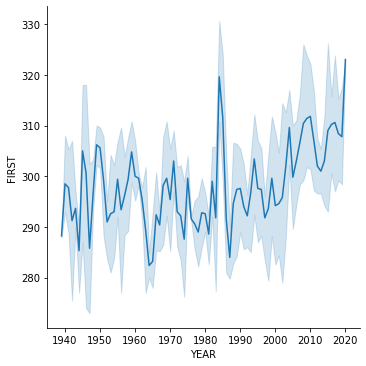

In [43]:
import seaborn as sns

# with multiple stations, show the mean and confidence intervals
sns.relplot(x="YEAR",y="FIRST", kind="line", data=fl)

In [134]:
#sns.scatterplot(data=fl, x="YEAR", y="LAST")

In [133]:
#sns.scatterplot(data=fl, x="YEAR", y="LAST")

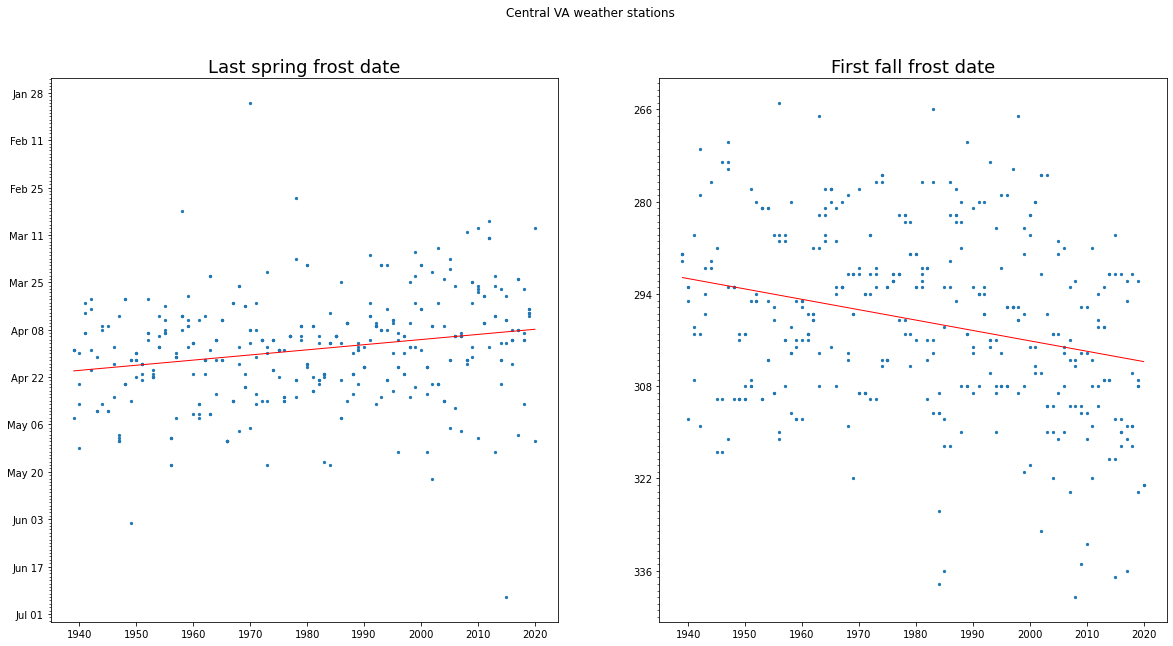

Average last frost date:
1939: Apr 20
2020: Apr 07
Average first frost date:
1939: Oct 18
2020: Oct 31


In [44]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

# 2 plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# set figure size in inches
fig.set_figheight(10)
fig.set_figwidth(20)

ax1.scatter(fl.YEAR, fl.LAST, s=5)

z = np.polyfit(fl.YEAR, fl.LAST, 1)
p = np.poly1d(z)
ax1.plot(fl.YEAR, p(fl.YEAR), "r", linewidth=1)

ax1.yaxis.set_major_locator(MultipleLocator(14))
ax1.yaxis.set_major_formatter(jmd_formatter)
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.invert_yaxis()

ax1.set_title('Last spring frost date', fontsize=18)

# first frost
ax2.scatter(fl.YEAR, fl.FIRST, s=5)

z2 = np.polyfit(fl.YEAR, fl.FIRST, 1)
p2 = np.poly1d(z2)
ax2.plot(fl.YEAR, p2(fl.YEAR), "r", linewidth=1)

ax2.yaxis.set_major_locator(MultipleLocator(14))
#ax2.yaxis.set_major_formatter(jmd_formatter)
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.invert_yaxis()

ax2.set_title('First fall frost date', fontsize=18)

fig.suptitle('Central VA weather stations', fontsize=12)

plt.show()

print('Average last frost date:')
print('1939: {}'.format(jmd_formatter(p(1939),0)))
print('2020: {}'.format(jmd_formatter(p(2020),0)))
#print('2020 actual last frost date: {}'.format(jmd_formatter(fl.loc[fl['YEAR']==2020,'LAST'],0)))
print('Average first frost date:')
print('1939: {}'.format(jmd_formatter(p2(1939),0)))
print('2020: {}'.format(jmd_formatter(p2(2020),0)))
#print('2020 actual first frost date: {}'.format(jmd_formatter(fl.loc[fl['YEAR']==2020,'FIRST'],0)))


In [30]:
# central va frosts
fig.savefig("cva_frosts.png", facecolor='white', bbox_inches='tight') # tight margins

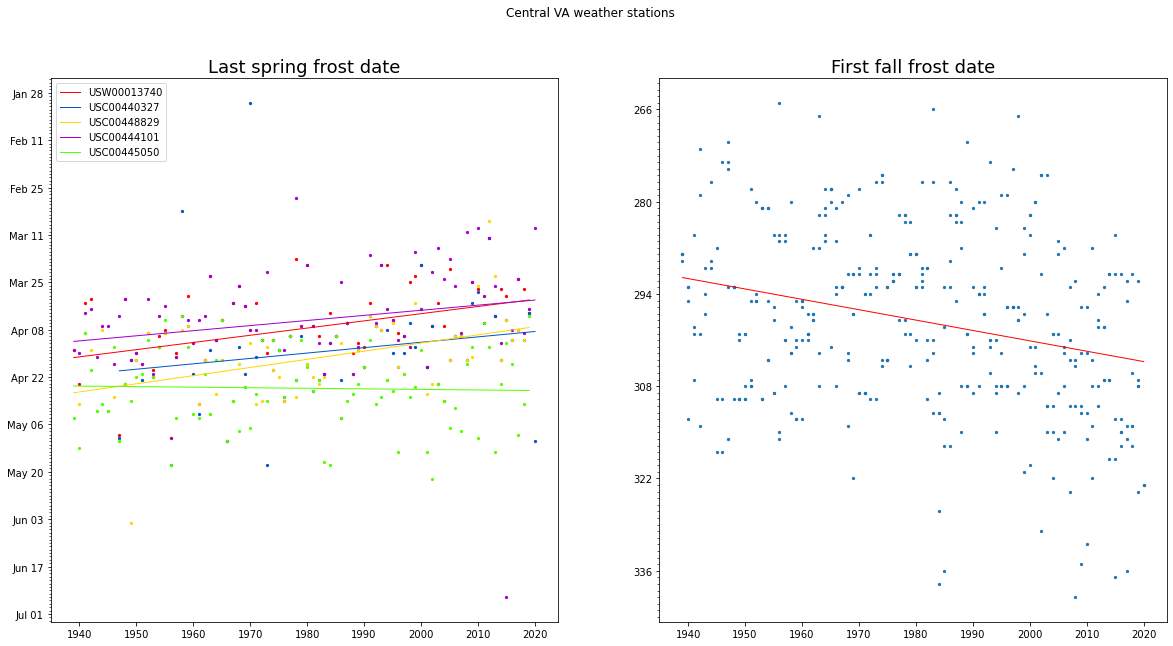

In [51]:
# plot stations separately
# 2 plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# set figure size in inches
fig.set_figheight(10)
fig.set_figwidth(20)

# http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
colormap = plt.cm.prism
colors = [colormap(i) for i in np.linspace(0,1,len(station_id_list))]

for i, s in enumerate(station_id_list):
    df = fl.loc[fl.ID==s,:]
    ax1.scatter(df.YEAR, df.LAST, s=5, color=colors[i])
    z = np.polyfit(df.YEAR, df.LAST, 1)
    p = np.poly1d(z)
    ax1.plot(df.YEAR, p(df.YEAR), "r", linewidth=1)
    
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])

ax1.legend(station_id_list, loc='upper left')
ax1.yaxis.set_major_locator(MultipleLocator(14))
ax1.yaxis.set_major_formatter(jmd_formatter)
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.invert_yaxis()

ax1.set_title('Last spring frost date', fontsize=18)

# first frost
ax2.scatter(fl.YEAR, fl.FIRST, s=5)

z2 = np.polyfit(fl.YEAR, fl.FIRST, 1)
p2 = np.poly1d(z2)
ax2.plot(fl.YEAR, p2(fl.YEAR), "r", linewidth=1)

ax2.yaxis.set_major_locator(MultipleLocator(14))
#ax2.yaxis.set_major_formatter(jmd_formatter)
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.invert_yaxis()

ax2.set_title('First fall frost date', fontsize=18)

fig.suptitle('Central VA weather stations', fontsize=12)

plt.show()

### Statistical analysis

In [53]:
fl.head()

,YEAR,ID,DAY,LAST,FIRST
0,1939,USC00444101,1939-04-14,104,289
1,1939,USC00445050,1939-05-04,124,288
2,1939,USC00448829,1939-04-14,104,288
3,1939,USW00013740,1939-04-14,104,288
4,1940,USC00444101,1940-04-14,105,295


In [54]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [55]:
X = fl[['YEAR']]
y = fl['FIRST']

X_train = X[:-10]
X_test = X[-10:]
y_train = y[:-10]
y_test = y[-10:]


In [65]:
# without test/train split
X_train = X
X_test = X
y_train = y
y_test = y

Coefficients: 
 [0.15741462]
Mean squared error: 168.25
Coefficient of determination: 0.07


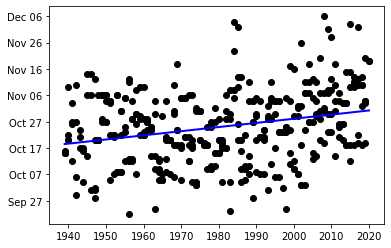

In [66]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=2)
plt.gca().yaxis.set_major_formatter(jmd_formatter)
plt.show()

<AxesSubplot:ylabel='FIRST'>

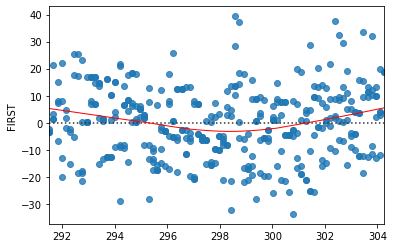

In [71]:
# Residuals vs fitted plot
sns.residplot(x=y_pred.reshape(-1), y='FIRST', data=fl,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})

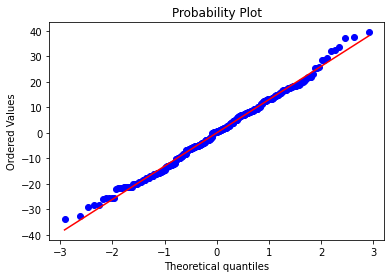

In [73]:
# QQ plot
import scipy.stats as stats

stats.probplot(fl['FIRST']-y_pred.reshape(-1), dist="norm", plot=plt)
plt.show()

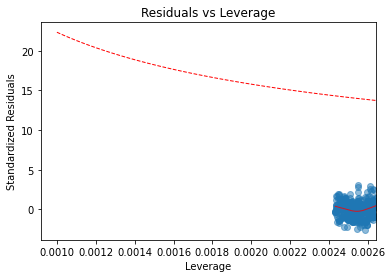

In [81]:
import statsmodels.api as sm

model = sm.OLS(fl['FIRST'], fl['YEAR'])
model_fit = model.fit()

# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(x=model_leverage, y=model_norm_residuals,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

# add cook's distance as a dotted line
p = len(model_fit.params)
x_range = np.linspace(0.001, max(model_leverage), 50)
y_range = (lambda x: np.sqrt((0.5 * p * (1 - x)) / x))(x_range)
plt.plot(x_range, y_range, label='Cooks distance', lw=1, ls='--', color='red')

Coefficients: 
 [ 2.32795057e+04 -2.33738371e+01  5.94212749e-03]
Mean squared error: 160.06
Coefficient of determination: 0.12


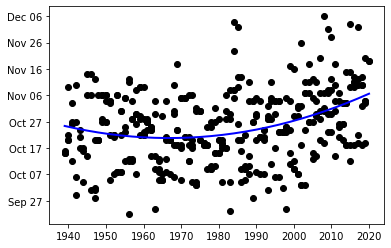

In [67]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
    ('linear', linear_model.LinearRegression(fit_intercept=False))])
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# The coefficients
print('Coefficients: \n', model.named_steps['linear'].coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=2)
plt.gca().yaxis.set_major_formatter(jmd_formatter)
plt.show()

Coefficients: 
 [0.         0.15740705]
Mean squared error: 168.25
Coefficient of determination: 0.07


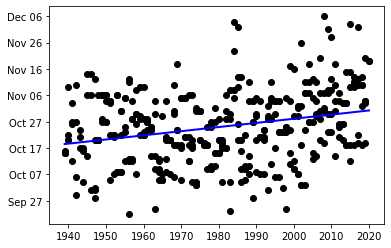

In [69]:
# deal with outliers?
model = Pipeline([('poly', PolynomialFeatures(degree=1)),
    ('ridge', linear_model.RidgeCV(fit_intercept=True))])
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# The coefficients
print('Coefficients: \n', model.named_steps['ridge'].coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=2)
plt.gca().yaxis.set_major_formatter(jmd_formatter)
plt.show()

In [31]:
import pymc3 as pm

In [ ]:
# try a pooled model first - 
with pm.Model() as model_pooled:

    # One shared intercept for all districts
    a = pm.Normal('a', mu=0, sigma=1)
    # model error
    sigma_y = pm.HalfCauchy('sigma_y',0.001)
    
    μ = a + sigma_y
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=df5['y'])